In [1]:
!pip install tensorboard

In [2]:
import yaml
from lstm import *
from mlp import *
from gensim.models import Word2Vec
import pandas as pd
import random
#tensorboard --logdir=/home/diego/Documentos/MTG_drafter/draftsym/runs --verbosity 0

random.seed(42)

In [3]:
# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
fi = open('config.yaml', 'r')
card_dict = yaml.load(fi, Loader=yaml.FullLoader)

In [10]:
def indice_para_nome(indice, cards_dict):
    """Converte um índice para o nome da carta correspondente usando o dicionário de cartas."""
    try:
        return cards_dict['cards_list'][indice]
    except IndexError:
        raise ValueError(f"Índice {indice} fora do alcance do dicionário de cartas.")


In [6]:
df_train = pd.read_csv('train_df.csv')
df_train = df_train.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
#df_train = df_train[:90]

In [7]:
word_to_vec_model = Word2Vec.load("card2vec.model")

In [8]:
from dataset_class import *

# Crie o dataset e o DataLoader
dataset = MagicDataset(df_train, word_to_vec_model, card_dict)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Itere sobre as primeiras 45 entradas do DataLoader
for i, (inputs, labels, mascara) in enumerate(dataloader):
    if i < 45:
        print(f"--- Entrada {i+1} ---")
        
        # Converta os embeddings para nomes
        input_names = [MagicDataset.embedding_para_nome(embedding.numpy(), word_to_vec_model) for embedding in inputs.squeeze(0)]
        
        # Converta o índice da label para o nome usando a função indice_para_nome
        label_name = indice_para_nome(labels.item(), card_dict)
        print(labels.item())
        print("Inputs:", input_names)
        print("Label:", label_name)
        print("Máscara:", mascara)
        print("\n")
        break
    else:
        break


--- Entrada 1 ---
70
Inputs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Label: Skyrider_Patrol
Máscara: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [2]:
# Instanciar o modelo LSTM
from torch import nn
from mlp import *
#model = LSTMModel()
model = FeedForwardModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [10]:
import os
import torch
from torch.utils.tensorboard import SummaryWriter
from dataset_class import *
from torch.utils.data import DataLoader

# Defina os hiperparâmetros
num_epochs = 20
batch_size = 32

# Configurar o TensorBoard SummaryWriter para escrever logs na pasta 'runs'
log_dir = './runs/model_3/'
writer = SummaryWriter(log_dir=log_dir)

# Defina um diretório para salvar os checkpoints
checkpoint_dir = 'checkpoints'

# Certifique-se de que o diretório exista (ou crie-o)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Criar o dataset e o DataLoader
dataset = MagicDataset(df_train, word_to_vec_model, card_dict)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Mover o modelo para a GPU
model.to(device)

# Ciclo de treinamento
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (inputs, labels, mascara) in enumerate(dataloader):
        # Mover as entradas e rótulos para a GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        mascara = mascara.to(device)

        # Zerar os gradientes
        optimizer.zero_grad()

        # Forward
        outputs = model(inputs, mascara)
        loss = criterion(outputs, labels)
        
        # Acumular a perda
        total_loss += loss.item()

        # Backward
        loss.backward()
        optimizer.step()

        # Calcular acertos
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calcular e imprimir a perda média e a acurácia da época
    average_loss = total_loss / len(dataloader)
    epoch_accuracy = correct_predictions / total_samples
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.4f}, Epoch Acuracy: {epoch_accuracy:.4f}")

    # Registrar no TensorBoard
    writer.add_scalar('Epoch Accuracy', epoch_accuracy, epoch)
    writer.add_scalar('Epoch Loss', average_loss, epoch)

    # Salvar o estado do modelo a cada 5 épocas
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_loss
        }
        checkpoint_path = os.path.join(checkpoint_dir, f'model_3_checkpoint_epoch_{epoch + 1}.pt')
        torch.save(checkpoint, checkpoint_path)

# Fechar o writer após terminar o treinamento
writer.close()


Epoch [1/50], Average Loss: 1.2374, Epoch Acuracy: 0.5667
Epoch [2/50], Average Loss: 1.1936, Epoch Acuracy: 0.5744
Epoch [3/50], Average Loss: 1.1874, Epoch Acuracy: 0.5753
Epoch [4/50], Average Loss: 1.1858, Epoch Acuracy: 0.5754
Epoch [5/50], Average Loss: 1.1861, Epoch Acuracy: 0.5746
Epoch [6/50], Average Loss: 1.1860, Epoch Acuracy: 0.5743
Epoch [7/50], Average Loss: 1.1874, Epoch Acuracy: 0.5735
Epoch [8/50], Average Loss: 1.1873, Epoch Acuracy: 0.5731
Epoch [9/50], Average Loss: 1.1868, Epoch Acuracy: 0.5726
Epoch [10/50], Average Loss: 1.1872, Epoch Acuracy: 0.5721
Epoch [11/50], Average Loss: 1.1871, Epoch Acuracy: 0.5721
Epoch [12/50], Average Loss: 1.1881, Epoch Acuracy: 0.5719
Epoch [13/50], Average Loss: 1.1891, Epoch Acuracy: 0.5713
Epoch [14/50], Average Loss: 1.1875, Epoch Acuracy: 0.5713
Epoch [15/50], Average Loss: 1.1867, Epoch Acuracy: 0.5716
Epoch [16/50], Average Loss: 1.1861, Epoch Acuracy: 0.5715
Epoch [17/50], Average Loss: 1.1845, Epoch Acuracy: 0.5722
Epoch 

KeyboardInterrupt: 

# Teste

In [31]:
import yaml
from lstm import *
from mlp import *
from gensim.models import Word2Vec
import pandas as pd

In [32]:
# Carregar o modelo e otimizador do checkpoint
def load_model_from_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss


In [33]:
df_test = pd.read_csv('test_df.csv')
df_test = df_test.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])

In [34]:
word_to_vec_model = Word2Vec.load("card2vec.model")

In [35]:
fi = open('config.yaml', 'r')
card_dict = yaml.load(fi, Loader=yaml.FullLoader)

In [52]:
# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = 'checkpoints/model_3_checkpoint_epoch_15.pt'  # Aqui, assumindo que você deseja carregar o "melhor" checkpoint

# Instanciar modelo e otimizador
model = FeedForwardModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Carregar o modelo do checkpoint
model, _, _, _ = load_model_from_checkpoint(model, optimizer, checkpoint_path)

In [53]:
import os
import torch
from dataset_class import *
from torch.utils.data import DataLoader

accuracy_per_round = np.zeros(45)

# Mover modelo para o dispositivo apropriado
model.to(device)
model.eval()

# Criar o dataset e o DataLoader para teste
dataset_test = MagicDataset(df_test, word_to_vec_model, card_dict)
test_loader = DataLoader(dataset_test, batch_size=45, shuffle=False)

# Variáveis para rastrear a precisão
total_samples = 0
correct_samples = 0

# Ciclo de teste
with torch.no_grad():
    for i, (inputs, labels, mascara) in enumerate(test_loader):
        # Mover entradas e rótulos para o dispositivo
        inputs = inputs.to(device)
        labels = labels.to(device)
        mascara = mascara.to(device)
        
        # Predição
        outputs = model(inputs, mascara)
        _, predicted = torch.max(outputs, 1)
        

        # Atualizar contadores de precisão
        total_samples += labels.size(0)
        correct_samples += (predicted == labels).sum().item()

        # Imprimir labels e predicted
        #print("Actual Labels:", labels.tolist())
        #print("Predicted Labels:", predicted.tolist())

        for j in range(len(inputs)):
            #input_names = [MagicDataset.embedding_para_nome(embedding.cpu().numpy(), word_to_vec_model) for embedding in inputs[j]]
            #print("Input Names:", input_names)
            #print("True Label:", indice_para_nome(labels[j].item(), card_dict))
            #print("Predicted Label:", indice_para_nome(predicted[j].item(), card_dict))
            #active_indices = torch.nonzero(mascara[j]).squeeze().tolist()
            #print("Mask:", active_indices)
            #print("-------------------------------")
            if predicted[j].item() == labels[j].item():
                accuracy_per_round[j] += 1

        # Opcional: Imprimir estatísticas a cada 100 lotes
        if i % 10000 == 0:
            print(f"Batch [{i+1}/{len(test_loader)}] - Accuracy: {100 * correct_samples / total_samples:.2f}%")

        #break

# Imprimir precisão final
print(f"Total Accuracy: {100 * correct_samples / total_samples:.2f}%")

accuracy_per_round = accuracy_per_round/(len(df_test)/45)

Batch [1/21590] - Accuracy: 64.44%
Batch [10001/21590] - Accuracy: 61.57%
Batch [20001/21590] - Accuracy: 61.50%
Total Accuracy: 61.51%


In [54]:
accuracy_per_round

array([0.68601204, 0.49157017, 0.50467809, 0.51116258, 0.51685966,
       0.52195461, 0.53788791, 0.55775822, 0.56614173, 0.58656786,
       0.60189903, 0.63765632, 0.66878184, 0.81954609, 1.        ,
       0.5913849 , 0.53714683, 0.53543307, 0.53047707, 0.54145438,
       0.54367763, 0.54701251, 0.56239   , 0.56864289, 0.58026864,
       0.60449282, 0.63052339, 0.66984715, 0.82306623, 1.        ,
       0.58462251, 0.55942566, 0.55155164, 0.54136174, 0.53705419,
       0.53862899, 0.54488189, 0.54997684, 0.55993516, 0.56614173,
       0.59194071, 0.61968504, 0.65609078, 0.80453914, 1.        ])

/home/diego/miniconda3/envs/mtg_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/diego/miniconda3/envs/mtg_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/diego/miniconda3/envs/mtg_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/diego/miniconda3/envs/mtg_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

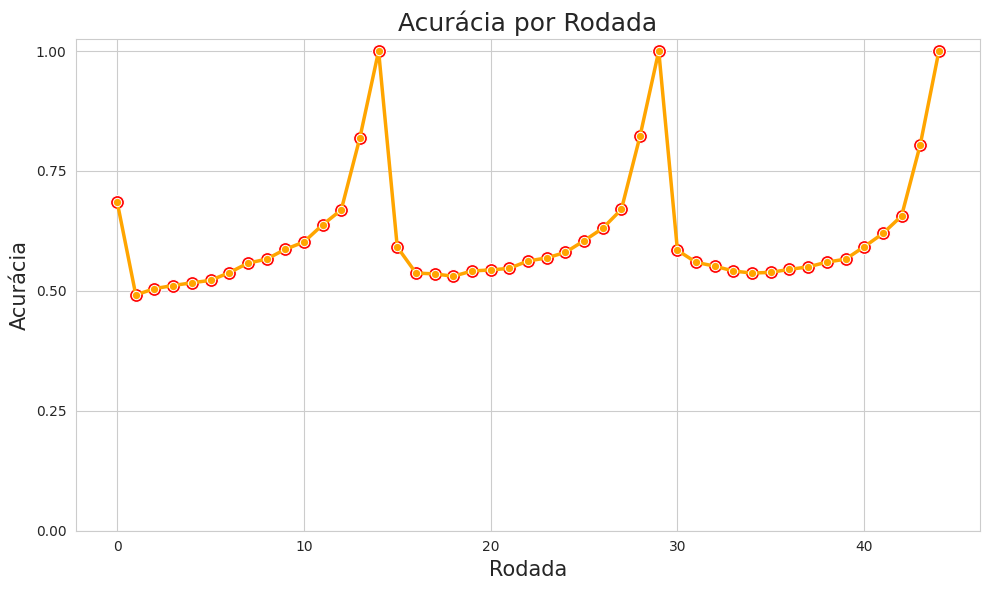

In [55]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Estilo do Seaborn
sns.set_style("whitegrid")

# Criando o gráfico
plt.figure(figsize=(10, 6))

# Plotando linha e pontos
sns.lineplot(x=np.arange(len(accuracy_per_round)), y=accuracy_per_round, linewidth=2.5, color='orange', marker='o')
sns.scatterplot(x=np.arange(len(accuracy_per_round)), y=accuracy_per_round, color='red', s=100)  # s define o tamanho dos pontos

# Adicionando título e rótulos
plt.title('Acurácia por Rodada', fontsize=18)
plt.xlabel('Rodada', fontsize=15)
plt.ylabel('Acurácia', fontsize=15)

# Fixando os ticks do eixo Y
plt.yticks([0, 0.25, 0.50, 0.75, 1])

plt.tight_layout()

# Exibir o gráfico
plt.show()


In [ ]:
61.56